# Answering Business Questions using SQL

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# helper function to quickly run queries and display as dataframes

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)

In [4]:
# helper function to quickly run SQL commands that wouldn't return dataframes

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

In [5]:
# helper function to display existing tables & views in the database

def show_tables():
    q = 'SELECT name, type FROM sqlite_master WHERE type IN ("table", "view")'
    return run_query(q)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce.

| Artist Name | Genre |
|-------|-------|
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [7]:
tracks_sold_per_genre = """
WITH
    track_genres AS
        (
            SELECT
                t.track_id,
                g.genre_id,
                g.name
            FROM track t
            LEFT JOIN genre g ON t.genre_id = g.genre_id
        ),
    invoice_tracks_usa AS
        (
            SELECT
                il.invoice_line_id,
                il.track_id
            FROM invoice_line il
            LEFT JOIN invoice i ON il.invoice_id = i.invoice_id
            WHERE i.billing_country = 'USA'
        )

SELECT
    g.name genre,
    COUNT(g.name) tracks_sold,
    CAST(COUNT(g.name) AS FLOAT) / CAST((SELECT COUNT(*) FROM invoice_tracks_usa) AS FLOAT) pct_of_total
FROM invoice_tracks_usa t
LEFT JOIN track_genres g ON t.track_id = g.track_id
GROUP BY 1
ORDER BY 2 DESC

"""

genre_sales_usa = run_query(tracks_sold_per_genre)
genre_sales_usa = genre_sales_usa.set_index('genre')
genre_sales_usa

,tracks_sold,pct_of_total
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


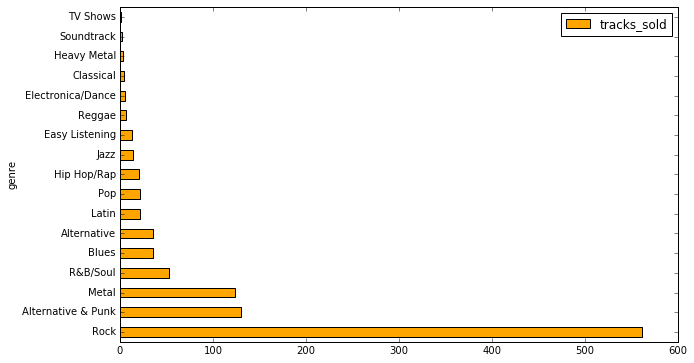

In [8]:
genre_sales_usa.plot.barh(y='tracks_sold', figsize=(10,6), color='orange')

As we can see above, the Rock genre sold far and away the most tracks in the USA.  However, none of the 4 artists we're selecting from fall within that genre.  Looking further down the list, we see that, of the 4 genres we're looking to select from, Punk (Alternative & Punk) is second.  Blues is next, followed by Pop, and then Hip-Hop.  Pop and Hip-Hop are close (separated by only 2 tracks sold, or ~0.1%), but Pop does win out here.

As a result, the recommendation of the first 3 artists whose albums we should list in our store are Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop).

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

Given that total sales is a historical value, and can be affected by the amount of time an employee has been with the organization, we'll include the `hire_date` column from the employee data when looking at sales support agents and their associated sales.

In [9]:
# create a 'total sales per customer' view in the database for use now and later

sales_per_customer_view = """
CREATE VIEW sales_per_customer AS
SELECT
    c.customer_id,
    c.first_name || ' ' || c.last_name customer_name,
    c.country,
    c.support_rep_id,
    TOTAL(i.total) total_spent,
    COUNT(i.invoice_id) num_purchases
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
GROUP BY 1
"""

run_command(sales_per_customer_view)

OperationalError: table sales_per_customer already exists

In [ ]:
run_query('SELECT * FROM sales_per_customer LIMIT 10')

In [ ]:
sales_per_rep = """
SELECT
    e.employee_id,
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date,
    TOTAL(s.total_spent) total_sales
FROM sales_per_customer s
LEFT JOIN employee e ON e.employee_id = s.support_rep_id
GROUP BY 1
"""

spr = run_query(sales_per_rep)
spr

In [ ]:
spr.plot.barh(x='employee_name', y='total_sales', figsize=(10,6))

At first glance, it appears that, of the 3 sales support agents, Jane Peacock demonstrates the highest performance (followed by Margaret Park and then Steve Johnson) based on total sales.

However, looking more closely at the hire dates, we can also see that Jane Peacock is the longest-tenured rep, having been employeed about a month longer than Margaret Park, and about 6.5 months longer than Steve Johnson.  As a result, we can point to differences in employment length as the primary factor in total sales differences between the reps.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, we have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we are going to group these customers as "Other" in our analysis.

In [44]:
sales_per_country = """
WITH sales_per_country AS
    (
        SELECT
            s.country,
            COUNT(s.customer_id) num_customers,
            TOTAL(s.total_spent) total_sales,
            SUM(s.num_purchases) num_purchases,
            CASE
                WHEN COUNT(s.customer_id) = 1 THEN 'Other'
                ELSE s.country
            END AS cust_country
        FROM sales_per_customer s
        GROUP BY 1
    )
    
SELECT
    cust_country country,
    SUM(num_customers) n_customers,
    TOTAL(total_sales) total_sales,
    TOTAL(total_sales) / SUM(num_customers) avg_spent_per_customer,
    TOTAL(total_sales) / SUM(num_purchases) avg_order_value
FROM
    (
        SELECT
            s.*,
            CASE
                WHEN s.cust_country = 'Other' THEN 1
                ELSE 0
            END AS sort
        FROM sales_per_country s
    )
    
GROUP BY 1
ORDER BY sort, 2 DESC

"""

spc = run_query(sales_per_country)
spc = spc.set_index('country')
spc

,n_customers,total_sales,avg_spent_per_customer,avg_order_value
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
United Kingdom,3,245.52,81.840000,8.768571
Czech Republic,2,273.24,136.620000,9.108000
India,2,183.15,91.575000,8.721429
Portugal,2,185.13,92.565000,6.383793


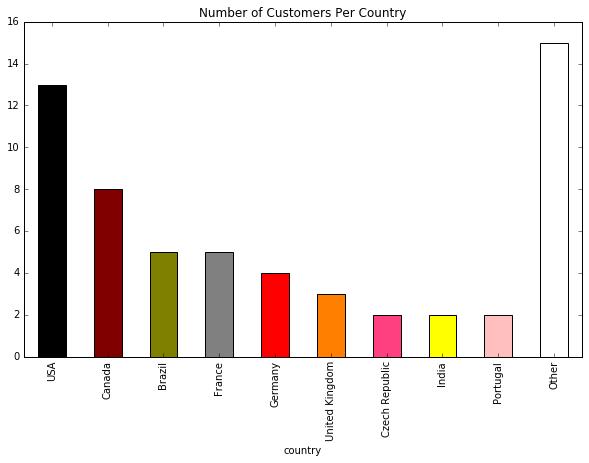

In [90]:
colors = [(0, 0, 0), (0.5, 0, 0), (0.5, 0.5, 0), (0.5, 0.5, 0.5), (1, 0, 0), (1, 0.5, 0), (1, 0.25, 0.5), (1, 1, 0), (1, 0.75, 0.75), (1, 1, 1)]

spc.plot(kind='bar', figsize=(10,6), y='n_customers', legend=False, title='Number of Customers Per Country', color=colors)

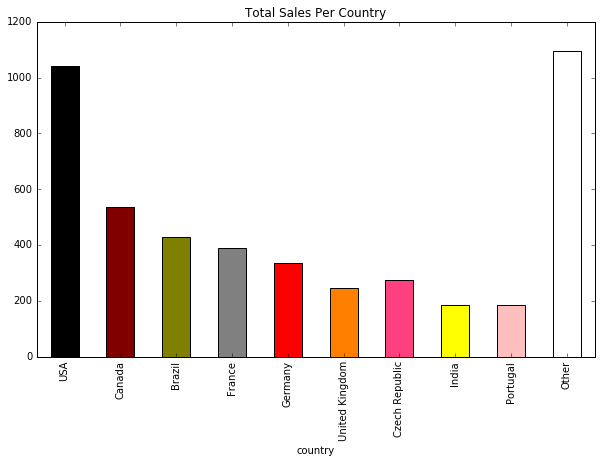

In [91]:
spc.plot(kind='bar', y='total_sales', figsize=(10,6), legend=False, title='Total Sales Per Country', color=colors)

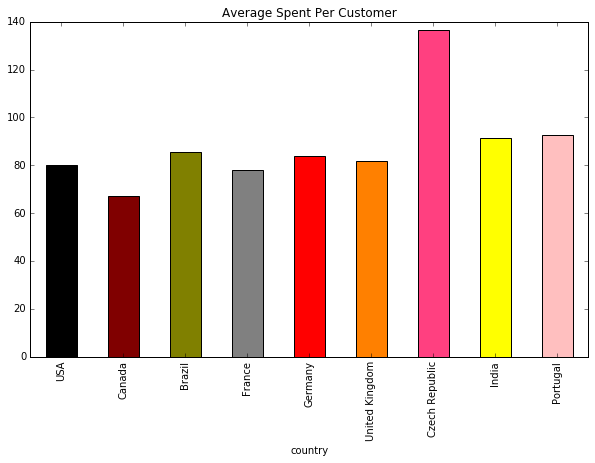

In [92]:
spc[:-1].plot(kind='bar', y='avg_spent_per_customer', figsize=(10,6), legend=False, title='Average Spent Per Customer', color=colors)

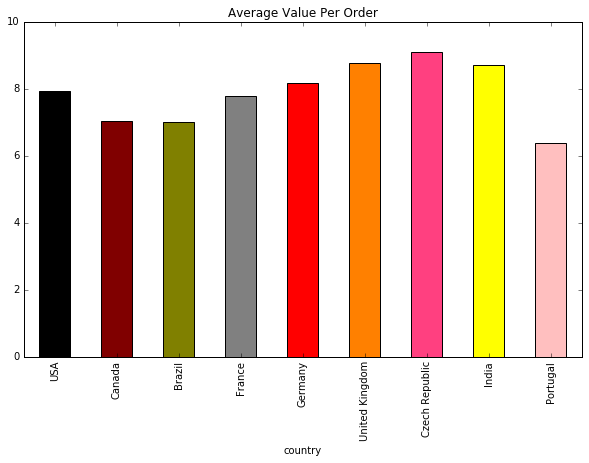

In [93]:
spc[:-1].plot(kind='bar', y='avg_order_value', figsize=(10,6), legend=False, title='Average Value Per Order', color=colors)

While countries grouped into "Other" make up a sizeable portion of total sales, they each had just one customer, which provides very little in the way of useful per-country data for running averages; thus, we left them out of the final two graphs.

As it is, the USA makes up a large amount of total sales, and its average spent-per-customer and average value-per-order values are on the lower end of the spectrum; making concentrating marketing efforts here seem unnecessary.

As for the other countries with multiple customers, of particular note are the Czech Republic and India (and the UK, to a lessser extent), who have two of the highest values for both average spent-per-customer and average value-per-order, but are two of the lowest in terms of total customers.  Given these numbers, there may be a lot of growth potential in those countries.

Based on our analysis, the recommendation is to concentrate marketing efforts, in particular, on the Czech Republic, India, and the UK.

## Albums vs. Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

We have two edge cases to consider:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [134]:
test = """
WITH

invoices_with_album AS
    (
        SELECT
            i.invoice_id,
            t.album_id
        FROM invoice_line il
        LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
        LEFT JOIN track t ON il.track_id = t.track_id
        GROUP BY 1
    ),

invoice_is_album AS
    (
        SELECT
            i.invoice_id,
            CASE
                WHEN
                    (
                    SELECT track_id
                    FROM invoice_line
                    WHERE invoice_id = i.invoice_id

                    EXCEPT

                    SELECT track_id
                    FROM track
                    WHERE album_id = i.album_id
                    ) IS NULL

                    AND

                    (
                    SELECT track_id
                    FROM track
                    WHERE album_id = i.album_id

                    EXCEPT

                    SELECT track_id
                    FROM invoice_line
                    WHERE invoice_id = i.invoice_id
                    ) IS NULL

                THEN 'Y'
                ELSE 'N'
                END AS is_album

        FROM invoices_with_album i
        ORDER BY 1
    )
    
SELECT
    is_album,
    COUNT(*) n_invoices,
    ROUND(CAST(COUNT(*) AS FLOAT) / CAST((SELECT COUNT(*) FROM invoice) AS FLOAT) * 100, 2) pct_of_total
FROM invoice_is_album
GROUP BY is_album


"""

run_query(test)

,is_album,n_invoices,pct_of_total
0,N,500,81.43
1,Y,114,18.57


Above, comparing the list of tracks from each invoice with the list of tracks from associated albums, we were able to establish a `Y` or `N` value for whether each invoice represented a full-album purchase or not.

We find that an overwhelming majority (~81%) of purchases were not straight full-album purchases, but rather sets of individually selected tracks.

Based on this data, the general prospective recommendation would be to not continue to buy full albums from record companies.